# Intro:
### In this notebook we load a .mat file with HRTF SH coefficients (and some other things) and optimize them to reduce the ILD error

| Variable           | dimensions                                                      | description |
| :----------------  | :------                                                         | :--- |
| p_f_high_lebedev   |  [$\Omega$ x positive frequencies x left/right]                 | Measured HRTF which represents the reference binaural signals from all directions |
| ILD_ref            |  [$f_c$ x $\Omega_{az}$ ]                                       | Reference ILD curve, based on the messured HRTF |
| f_band             |  [$f_{low}$ , $f_{high}$]                                       | The lower and upper frequency band for the ILD calculations |
| Hnm_low            |  [$(N_{low}+1)^2$ x positive frequencies x  left/right ]        | The SH least squeres coefficients |
| Hnm_mls            |  [$(N_{low}+1)^2$ x positive frequencies x  left/right ]        | The SH magnitude least squeres coefficients |
| Hnm_high           |  [$(N_{high}+1)^2$ x positive frequencies x  left/right ]       | The high order SH least squeres coefficients |
| fs                 |  scalar                                                         | sample rate |
| N_low              |  scalar                                                         | low order |
| N_high             |  scalar                                                         | high order for refference |
| f_vec              |  [$f$ x 1]                                                      | positive frequencies bins vector |
| ang_vec            |  [$\Omega_{az}$ x 1]                                            | Angles in degrees for ILD calculations |
| Y_high_lebedev     |  [$\Omega$ x $(N_{high}+1)^2$]                                  | SH matrix for high order over lebedev directions |
| Y_high_az          |  [$\Omega_{az}$ x $(N_{high}+1)^2$]                             | SH matrix for high order over azimuth directions |
| Y_low_lebedev      |  [$\Omega$ x $(N_{low}+1)^2$]                                   | SH matrix for low order over lebedev directions |
| Y_low_az           |  [$\Omega_{az}$ x $(N_{low}+1)^2$]                              | SH matrix for low order over azimuth directions |
| omega              |  [$\Omega$]                                                     | first row is elevation second row is azimuth for sphirical grid |
| omega_az           |  [$\Omega_{az}$]                                                | first row is elevation second row is azimuth for lateral grid |


In [2]:
import os
import sys
import time
TORCHAUDIO_USE_BACKEND_DISPATCHER=0
sys.path.append('.')

import scipy.io
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(threshold=4)

import local_functions as funk
import NN_optimizer as nn_opt
import ITD_estimator as itd_est

import pyfar as pf
import sofar as sf

import matplotlib.pyplot as plt

import pickle

import torch

Python Platform: macOS-13.4.1-arm64-i386-64bit
PyTorch Version: 2.2.2

Python 3.10.14 (main, Mar 21 2024, 11:21:31) [Clang 14.0.6 ]
NVIDIA/CUDA GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is cpu


----------Variables------------
p_f_high_lebedev torch.Size([2702, 257, 2]) 	 torch.complex128
ILD_ref 	 torch.Size([22, 361]) 		 torch.float64

Hnm_high	 torch.Size([1849, 257, 2]) 	 torch.complex128
Hnm_low		 torch.Size([4, 257, 2]) 	 torch.complex128
Hnm_mls		 torch.Size([4, 257, 2]) 	 torch.complex128

Y_high_lebedev	 torch.Size([2702, 1849]) 	 torch.complex128
Y_high_az	 torch.Size([361, 1849]) 	 torch.complex128
Y_low_lebedev	 torch.Size([2702, 4]) 		 torch.complex128
Y_low_az	 torch.Size([361, 4]) 		 torch.complex128

f_band		 (2,) 				 uint16
fs		 () 				 uint16
f_vec		 (257, 1) 			 float64
ang_vec		 (361, 1) 			 float64
N_high		 (1,) 				 uint8
N_low		 (1,) 				 uint8


-----------NN summary---------
Layer (type (var_name))                  Kernel Shape  Input S

Loading...:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/orberebi/anaconda3/envs/TUB-BGU-colab/lib/python3.10/site-packages/pyfar/samplings/spatial.py:115: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.calculate_sampling_weights.'
  warnings.warn((
/Users/orberebi/anaconda3/envs/TUB-BGU-colab/lib/python3.10/site-packages/pyfar/samplings/spatial.py:44: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.spherical_voronoi.'
  warnings.warn((


Finished Training


/Users/orberebi/Documents/GitHub/TUB-BGU-colab/PyTorch/NN_optimizer.py:935: RuntimeWarning: invalid value encountered in divide
  normalized_h_nmse = h_nmse / max_value
/Users/orberebi/Documents/GitHub/TUB-BGU-colab/PyTorch/NN_optimizer.py:938: RuntimeWarning: invalid value encountered in divide
  normalized_h_mag = h_mag / max_value
/Users/orberebi/Documents/GitHub/TUB-BGU-colab/PyTorch/NN_optimizer.py:941: RuntimeWarning: invalid value encountered in divide
  normalized_h_ILD = h_ILD / max_value
/Users/orberebi/Documents/GitHub/TUB-BGU-colab/PyTorch/NN_optimizer.py:944: RuntimeWarning: invalid value encountered in divide
  normalized_h_diff = h_diff / max_value
/Users/orberebi/Documents/GitHub/TUB-BGU-colab/PyTorch/NN_optimizer.py:947: RuntimeWarning: invalid value encountered in divide
  normalized_h_color = h_color / max_value
/Users/orberebi/Documents/GitHub/TUB-BGU-colab/PyTorch/NN_optimizer.py:953: RuntimeWarning: invalid value encountered in divide
  normalized_h_color_weighted

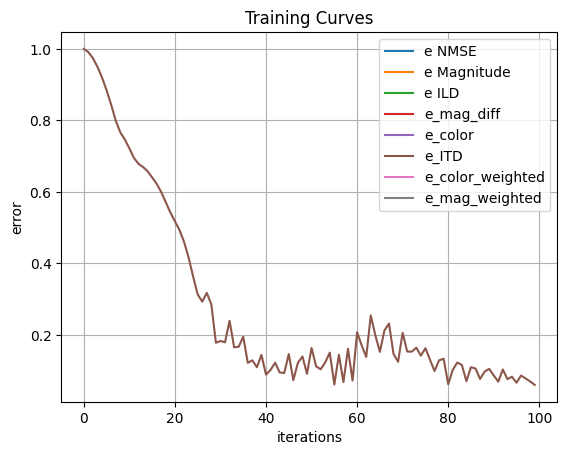

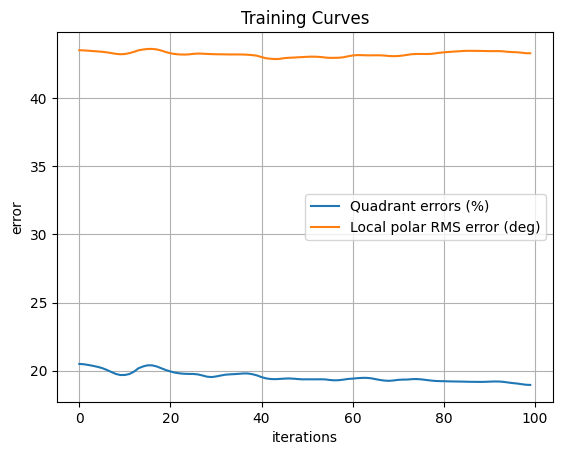

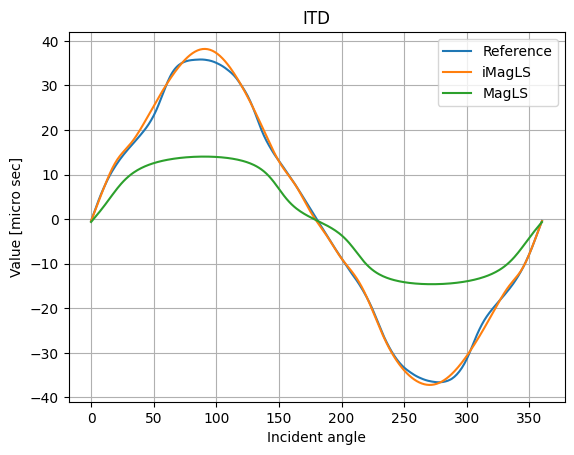

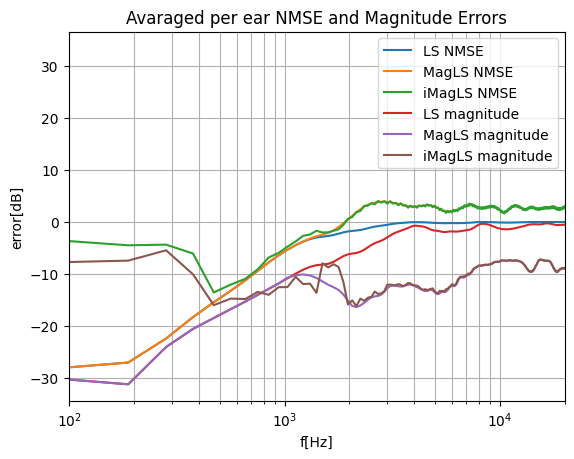

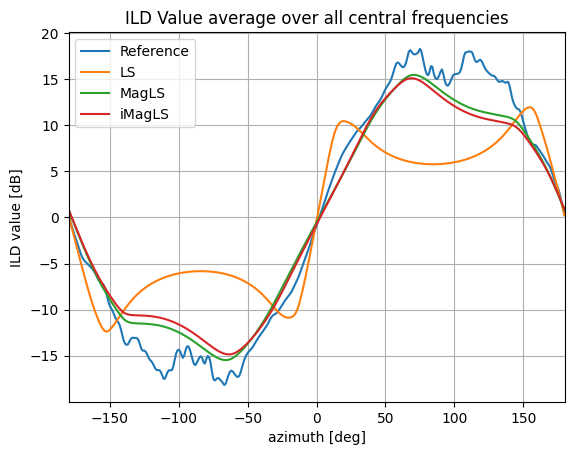

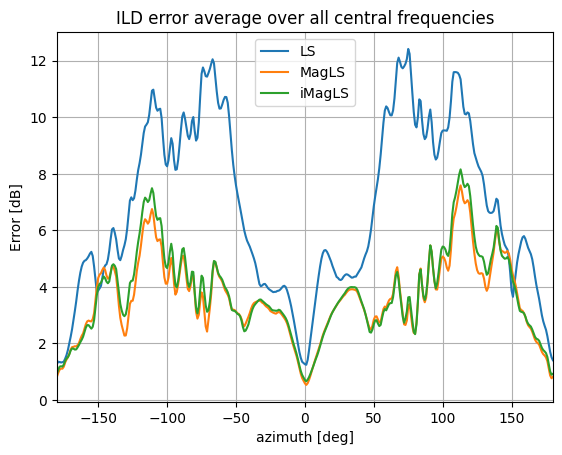

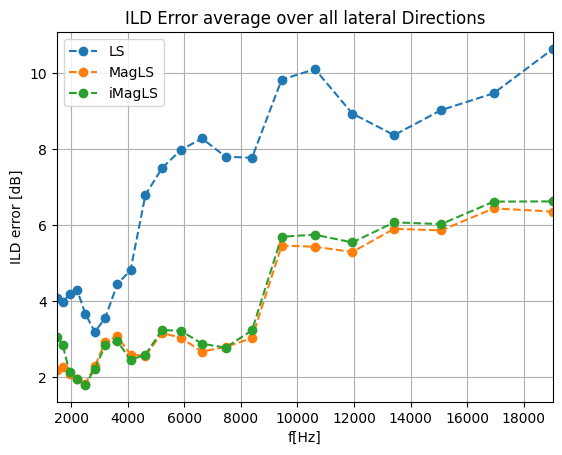

In [3]:
# The following block usees the path_matlab_data to load the data and calculate the iMagLS HRTF coeeftients
is_save = True
save_folder = "01_05_24-post_grad_mask/"
base_dir = os.path.join('..')
path_matlab_data = os.path.join(
    base_dir, "matlab_saved_data", "11_04_24", "KU100_HRIR_L2702_N1.mat")
results_save_path = os.path.join(
    base_dir, "PyTorch", "results", save_folder)

drive_path = "/Users/orberebi/Library/CloudStorage/GoogleDrive-berebio@post.bgu.ac.il/"
drive_path = os.path.join(drive_path, "My Drive/research/iMagLS/TUB-Alurazation")
results_save_path_gdrive = os.path.join(
    drive_path, save_folder)

if is_save:
    if not os.path.isdir(results_save_path):
        os.makedirs(results_save_path)
            

lambda_vec=[0,0,0,0,0,1,0,0]

# lambda_vec[0] - ILD error
# lambda_vec[1] - MSE error
# lambda_vec[2] - magnitude error
# lambda_vec[3] - diff error
# lambda_vec[4] - colorization error
# lambda_vec[5] - ITD error
# lambda_vec[6] - colorization error weighted
# lambda_vec[7] - magnitude error weighted

float_string ="lambda-vec-" + "_".join(str(x) for x in lambda_vec)

results_save_path =  os.path.join( results_save_path_gdrive,float_string)
filename = "/data" + ".pkl"


epochs = 100
res_out = nn_opt.start(path_matlab_data,results_save_path,epochs,lambda_vec,shutup=False,is_save=is_save)


results_save_path_data = os.path.join(results_save_path, "data" )
if not os.path.isdir(results_save_path_data):
        os.makedirs(results_save_path_data)

if is_save:
    with open(results_save_path_data+filename, 'wb') as f:
        pickle.dump(res_out, f)





In [8]:
foo = results_save_path_data+filename
with open(foo, 'rb') as f:
    loaded_dict = pickle.load(f)

Hnm_imls       = loaded_dict["Hnm_imls"]
Hnm_mls        = loaded_dict["Hnm_mls"]
Hnm_high       = loaded_dict["Hnm_high"]
Y_high_az      = loaded_dict["Y_high_az"]
Y_low_az       = loaded_dict["Y_low_az"]
Y_high_lebedev = loaded_dict["Y_high_lebedev"]
Y_low_lebedev  = loaded_dict["Y_low_lebedev"]
fs             = loaded_dict["fs"]
omega          = loaded_dict["omega"]
omega_az       = loaded_dict["omega_az"]

In [ ]:
# This one works well, don't touch

# The following block usees the path_matlab_data to load the data and calculate the iMagLS HRTF coeeftients
base_dir = os.path.join('..')
path_matlab_data = os.path.join(
    base_dir, "matlab_saved_data", "11_04_24", "KU100_HRIR_L2702_N1.mat")
results_save_path = os.path.join(
    base_dir, "PyTorch", "results", "10_04_24/")
lambda_vec=[2,1,1,1.5,0]
epochs = 100
Hnm_imls, Hnm_mls, Hnm_high, Y_high_az, Y_low_az,Y_high_lebedev,Y_low_lebedev, fs, omega, omega_az = nn_opt.start(path_matlab_data,
                                                                                                 results_save_path,epochs,lambda_vec,
                                                                                                 shutup=True,is_save=False)



## Source Alurazation

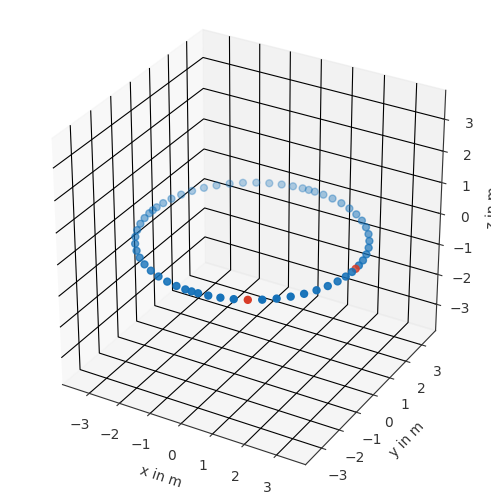

start angle:  [0, 0]  [deg]

[=============================] (298,000)[az,el]

end angle:  [298, 0] [deg]
signal time:  7.520333333333333  seconds
angle speed:  6.781614290146713  deg per sec
total frame number:  51  (including 50% overlap)
num of sampels in each frame:  13865  [samples]

 Saving to disk

 Done...




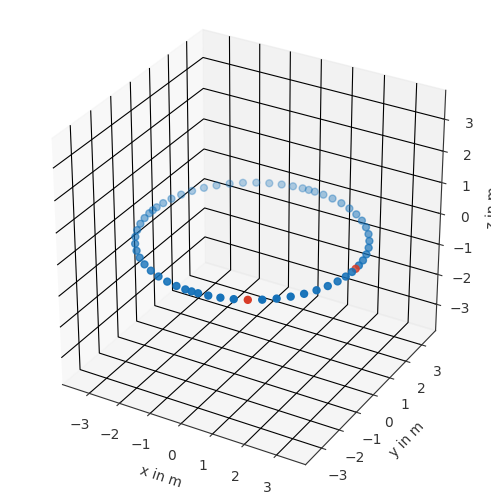

start angle:  [0, 0]  [deg]

[=============================] (298,000)[az,el]

end angle:  [298, 0] [deg]
signal time:  7.520333333333333  seconds
angle speed:  6.781614290146713  deg per sec
total frame number:  51  (including 50% overlap)
num of sampels in each frame:  13865  [samples]

 Saving to disk

 Done...




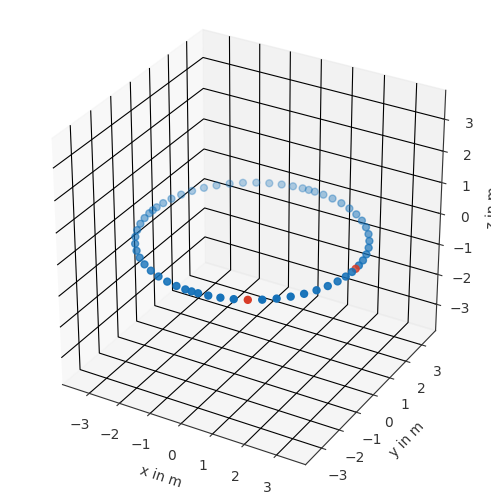

start angle:  [0, 0]  [deg]

[=============================] (298,000)[az,el]

end angle:  [298, 0] [deg]
signal time:  7.520333333333333  seconds
angle speed:  6.781614290146713  deg per sec
total frame number:  51  (including 50% overlap)
num of sampels in each frame:  13865  [samples]

 Saving to disk

 Done...




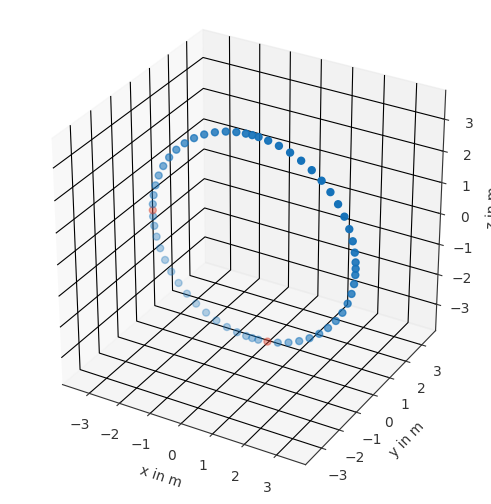

start angle:  [0, -81]  [deg]

[=============================] (180,000)[az,el]

end angle:  [180, 0] [deg]
signal time:  7.520041666666667  seconds
angle speed:  5.851031410508585  deg per sec
total frame number:  44  (including 50% overlap)
num of sampels in each frame:  16021  [samples]

 Saving to disk

 Done...




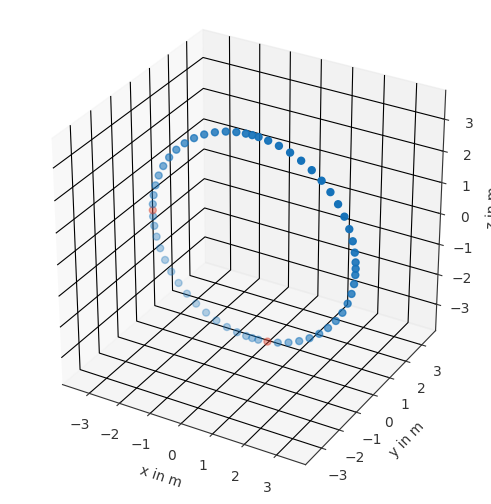

start angle:  [0, -81]  [deg]

[=============================] (180,000)[az,el]

end angle:  [180, 0] [deg]
signal time:  7.520041666666667  seconds
angle speed:  5.851031410508585  deg per sec
total frame number:  44  (including 50% overlap)
num of sampels in each frame:  16021  [samples]

 Saving to disk

 Done...




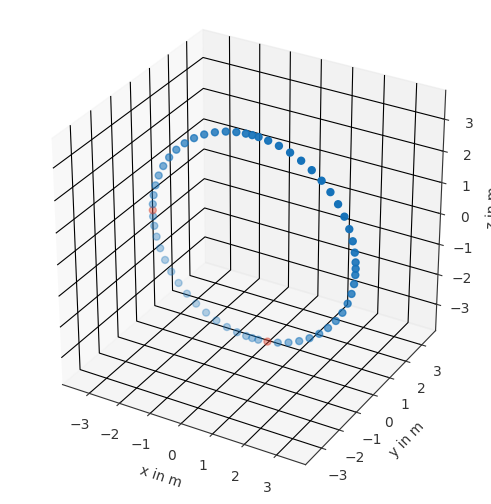

start angle:  [0, -81]  [deg]

[=============================] (180,000)[az,el]

end angle:  [180, 0] [deg]
signal time:  7.520041666666667  seconds
angle speed:  5.851031410508585  deg per sec
total frame number:  44  (including 50% overlap)
num of sampels in each frame:  16021  [samples]

 Saving to disk

 Done...




In [9]:
# Function to print a loading bar
def print_loading_bar(progress,ang):
    bar_length = 29
    ang_az = ang[0]
    ang_el = ang[1]
    filled_length = int(progress * bar_length)
    bar = '=' * filled_length + '-' * (bar_length - filled_length)
    print(f'\r[{bar}] ({ang_az:03d},{ang_el:03d})[az,el]', end='', flush=True)


def gen_source_alurazation(angles,az_el_flag,Hnm,Ynm,Omega,dry_sig_path,save_path,save_name,fs):
    bp = [20, 20e3]
    dry_sig    = pf.io.read_audio(dry_sig_path)
    HRIR       = funk.spatial_interpolation(Hnm,Ynm,True).cpu().numpy()
    HRIR       = np.transpose(HRIR,[0,2,1])
    HRIR_pf    = pf.Signal(HRIR, fs)
    HRIR_pf    = pf.dsp.filter.butterworth(HRIR_pf, 8, bp, btype='bandpass')

    # Convert Omega to pf.Coordinates
    coardinate = pf.Coordinates.from_spherical_colatitude(Omega[:,1],Omega[:,0],Omega[:,2]) # [az, el, r]

    # Get the the idecies of the lateral of median plane (azimuth == 0 or 180)    
    if az_el_flag:
        mask = np.squeeze(np.logical_or(coardinate.azimuth == 0, coardinate.azimuth == np.pi))
        coardinate_new_plane = coardinate[mask]
        sort = np.argsort(coardinate_new_plane.polar)
        coardinate_new_plane = coardinate_new_plane[sort]
        # Convert angles to pf.Coordinates
        angles = np.deg2rad(angles)
        az_column = np.full((angles.shape[0], 1),0)
        radius_column = np.full((angles.shape[0], 1), Omega[0,2])
        # Stack the original matrix with the constant column horizontally
        angles = np.hstack((az_column, angles))
        angles = np.hstack((angles, radius_column))
        to_find = pf.Coordinates.from_spherical_side(angles[:,0], angles[:,1],  angles[:,2])
        # find the first and last indices in coardinate_new_plane acodring to angles
        index, distance = coardinate_new_plane.find_nearest(to_find)
        
    else:
        tol = np.deg2rad(0.5)
        mask = np.squeeze(np.logical_and(coardinate.elevation <= (0+tol),coardinate.elevation >= (0-tol)))
        coardinate_new_plane = coardinate[mask]
        sort = np.argsort(coardinate_new_plane.azimuth)
        coardinate_new_plane = coardinate_new_plane[sort]
        # Convert angles to pf.Coordinates
        angles = np.deg2rad(angles)
        el_column = np.full((angles.shape[0], 1),np.pi/2)
        radius_column = np.full((angles.shape[0], 1), Omega[0,2])
        # Stack the original matrix with the constant column horizontally
        angles = np.hstack((angles, el_column))
        angles = np.hstack((angles, radius_column))
        to_find = pf.Coordinates.from_spherical_colatitude(angles[:,0], angles[:,1],  angles[:,2])
        # find the first and last indices in coardinate_new_plane acodring to angles
        index, distance = coardinate_new_plane.find_nearest(to_find)
    

    HRIR_pf = HRIR_pf[mask,:]
    HRIR_pf = HRIR_pf[sort]

    
    
    
    coardinate_new_plane.show(index)
    plt.show()
    num_of_HRIRs = index[0][1] - index[0][0] +1
  

    # using 50% overlap between two adjacent points using triangular window ###
   
    stride = np.ceil(dry_sig.n_samples / (num_of_HRIRs+1)).astype(int)
    window_len_samples = 2*stride + 1

    add_zeros = stride*(num_of_HRIRs+1) - dry_sig.n_samples
    # Zero pad the dry signal so the windows will fit
    padded = np.zeros((1,1+stride*(num_of_HRIRs+1)))
    padded[:, :dry_sig.time.shape[1]] = dry_sig.time
    dry_sig = pf.Signal(padded, dry_sig.sampling_rate)

    # initialize output signal
    output_signal = pf.Signal(np.zeros(dry_sig.n_samples+HRIR_pf.n_samples), dry_sig.sampling_rate)

    
    # create a triangular window
    window = np.bartlett(window_len_samples)

    # the length of the signals in term of window length
    signal_frames_len = int(output_signal.n_samples / window_len_samples)


    # initialize output signal
    output_signal = pf.Signal(np.zeros(dry_sig.n_samples+HRIR_pf.n_samples), dry_sig.sampling_rate)


    
    for frame_idx in range(num_of_HRIRs):
        first_sample = frame_idx*stride
        last_sample  = frame_idx*stride+window_len_samples
        curr_corr_index = index[0][0] + frame_idx
        curr_ang = [np.round(np.rad2deg(coardinate_new_plane.azimuth[curr_corr_index])).astype(int),np.round(np.rad2deg(coardinate_new_plane.elevation[curr_corr_index])).astype(int)]


        
        curr_window = np.pad(window, (first_sample, dry_sig.n_samples - last_sample), 'constant', constant_values=(0, 0))
        if frame_idx == 0:
            curr_window[:stride] = 1
        elif frame_idx == num_of_HRIRs - 1:
            curr_window[-stride:] = 1
            
        curr_window_pf = pf.Signal(curr_window, dry_sig.sampling_rate)
        dry_sig_window = pf.multiply((dry_sig, curr_window_pf), domain='time')

        '''
        plt.figure()
        pf.plot.time(curr_window_pf)
        plt.show()
        '''

        if frame_idx == 0:
            print("start angle: ",curr_ang," [deg]\n")
            output_signal = pf.dsp.convolve(HRIR_pf[curr_corr_index],dry_sig_window)
        else:
            output_signal = output_signal + pf.dsp.convolve(HRIR_pf[curr_corr_index],dry_sig_window)
        # Simulate progress
        print_loading_bar(((frame_idx+1) / num_of_HRIRs),curr_ang)
        #print_loading_bar((frame_idx / num_of_HRIRs),4)
        time.sleep(0.01)  # Simulate some work being done


    
    print("\n\nend angle: ",curr_ang,"[deg]")
    sig_length_time = output_signal.n_samples / fs
    movmentspeed = (num_of_HRIRs) / sig_length_time
    movmentspeed_in_sample = (num_of_HRIRs) /  output_signal.n_samples



    print("signal time: ", sig_length_time," seconds")
    print("angle speed: ", movmentspeed," deg per sec")
    print("total frame number: ", num_of_HRIRs," (including 50% overlap)")
    print("num of sampels in each frame: ", window_len_samples," [samples]")


    
    print("\n Saving to disk")
    output_signal    = pf.dsp.normalize(output_signal,channel_handling='max')
    '''
    plt.figure()
    pf.plot.time(output_signal)
    plt.show()
    '''
    tmp = save_path+"/"+save_name+".wav"
    pf.io.write_audio(output_signal,tmp)
    print("\n Done...\n\n")
    



radius = 3.25
# Create the third column with a constant value of 3.25
radius = np.full((omega.shape[0],1), radius)
# Stack the original matrix with the constant column horizontally
new_omega = np.hstack((omega, radius))

save_data_path = os.path.join(results_save_path, "Auralization")
dry_sig_name = "casta.wav"
save_data_path =  os.path.join(save_data_path, dry_sig_name.split(".")[0])
dry_sig_path = os.path.join(base_dir, "dry_signals", dry_sig_name)

median_flag = False # the median of lateral plane flag, if True then median of false then lateral

if median_flag:
    save_data_path_aura =  os.path.join(save_data_path, "Median_Plane")
else:
    save_data_path_aura =  os.path.join(save_data_path, "Horizontal_Plane")
#srat_stop_angles = np.atleast_2d(np.array([-80,180])).T; # if lateral then 0:360 where 90 is the left ear, if madian the use polar -90:270 where 0 is front and -90 is down, 90 is up and 180 is back
srat_stop_angles = np.atleast_2d(np.array([0,300])).T; # if lateral then 0:360 where 90 is the left ear, if madian the use polar -90:270 where 0 is front and -90 is down, 90 is up and 180 is back

if not os.path.isdir(save_data_path_aura):
        os.makedirs(save_data_path_aura)

save_name = "HOA_reference"
gen_source_alurazation(srat_stop_angles,median_flag,Hnm_high,Y_high_lebedev,new_omega,dry_sig_path,save_data_path_aura,save_name,fs)

save_name = "iMagLS"
gen_source_alurazation(srat_stop_angles,median_flag,Hnm_imls,Y_low_lebedev,new_omega,dry_sig_path,save_data_path_aura,save_name,fs)

save_name = "MagLS"
gen_source_alurazation(srat_stop_angles,median_flag,Hnm_mls,Y_low_lebedev,new_omega,dry_sig_path,save_data_path_aura,save_name,fs)



median_flag = True # the median of lateral plane flag, if True then median of false then lateral

if median_flag:
    save_data_path_aura =  os.path.join(save_data_path, "Median_Plane")
else:
    save_data_path_aura =  os.path.join(save_data_path, "Lateral_Plane")
srat_stop_angles = np.atleast_2d(np.array([-80,180])).T; # if lateral then 0:360 where 90 is the left ear, if madian the use polar -90:270 where 0 is front and -90 is down, 90 is up and 180 is back
#srat_stop_angles = np.atleast_2d(np.array([0,300])).T; # if lateral then 0:360 where 90 is the left ear, if madian the use polar -90:270 where 0 is front and -90 is down, 90 is up and 180 is back

if not os.path.isdir(save_data_path_aura):
        os.makedirs(save_data_path_aura)

save_name = "HOA_reference"
gen_source_alurazation(srat_stop_angles,median_flag,Hnm_high,Y_high_lebedev,new_omega,dry_sig_path,save_data_path_aura,save_name,fs)

save_name = "iMagLS"
gen_source_alurazation(srat_stop_angles,median_flag,Hnm_imls,Y_low_lebedev,new_omega,dry_sig_path,save_data_path_aura,save_name,fs)

save_name = "MagLS"
gen_source_alurazation(srat_stop_angles,median_flag,Hnm_mls,Y_low_lebedev,new_omega,dry_sig_path,save_data_path_aura,save_name,fs)






## Static source - save .wav files to disk

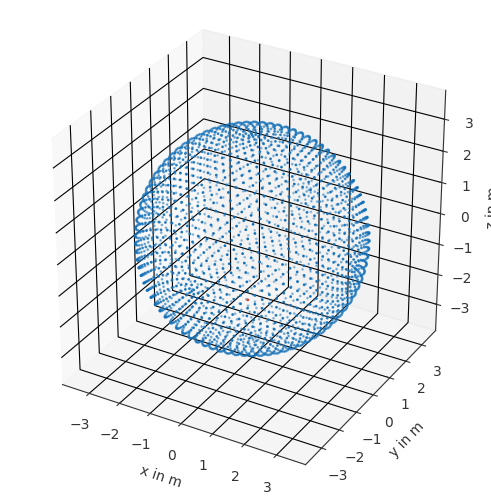


 Saving to disk

 Done...




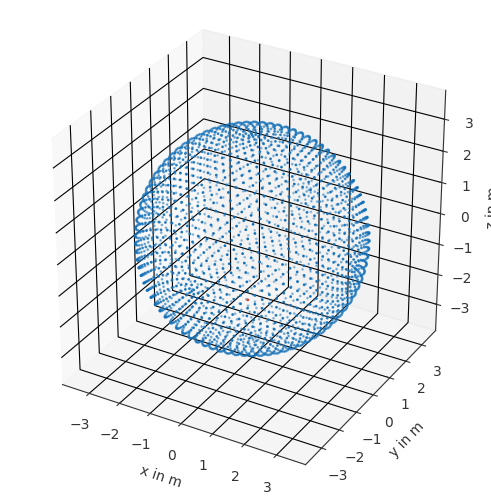


 Saving to disk

 Done...




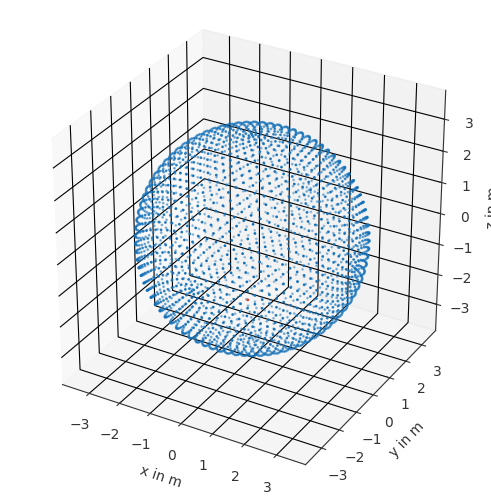


 Saving to disk

 Done...




In [10]:
def get_static_source(ang,Hnm,Ynm,Omega,dry_sig_path,save_path,save_name,fs):
    bp = [8e3, 20e3]
    dry_sig    = pf.io.read_audio(dry_sig_path)
    dry_sig    = pf.dsp.filter.butterworth(dry_sig, 8, bp, btype='bandpass')
    HRIR       = funk.spatial_interpolation(Hnm,Ynm,True).cpu().numpy()
    HRIR       = np.transpose(HRIR,[0,2,1])
    HRIR_pf    = pf.Signal(HRIR, fs)
    #HRIR_pf    = pf.dsp.filter.butterworth(HRIR_pf, 8, bp, btype='bandpass')

    # Convert Omega to pf.Coordinates
    coardinate = pf.Coordinates.from_spherical_colatitude(Omega[:,1],Omega[:,0],Omega[:,2]) # [az, el, r]
    ang = np.deg2rad(ang)
    radius_column = np.full((ang.shape[0], 1), Omega[0,2])
    # Stack the original matrix with the constant column horizontally
    ang = np.hstack((ang, radius_column))
    to_find = pf.Coordinates.from_spherical_colatitude(ang[:,0], ang[:,1],  ang[:,2])
    # find the index in coardinate to angles
    index, distance = coardinate.find_nearest(to_find)
    coardinate.show(index)
    plt.show()
    output_signal = pf.dsp.convolve(HRIR_pf[index],dry_sig)
    print("\n Saving to disk")
    output_signal    = pf.dsp.normalize(output_signal,channel_handling='max')
    tmp = save_path+"/"+save_name+".wav"
    pf.io.write_audio(output_signal,tmp)
    print("\n Done...\n\n")
    


    
ang = np.atleast_2d(np.array([-60,90])) # (1,2) ang[0,0]=azimuth and ang[0,1]=elevation (spherical elevation system)

save_data_path = os.path.join(results_save_path, "Auralization")
dry_sig_name = "casta.wav"
dry_sig_path = os.path.join(base_dir, "dry_signals", dry_sig_name)
save_data_path =  os.path.join(save_data_path, dry_sig_name.split(".")[0])
foo = "Static_" + np.array2string(ang[0])
save_data_path =  os.path.join(save_data_path, foo)



if not os.path.isdir(save_data_path):
        os.makedirs(save_data_path)

radius = 3.25
# Create the third column with a constant value of 3.25
radius = np.full((omega.shape[0],1), radius)
# Stack the original matrix with the constant column horizontally
new_omega = np.hstack((omega, radius))

save_name = "HOA_reference"
get_static_source(ang,Hnm_high,Y_high_lebedev,new_omega,dry_sig_path,save_data_path,save_name,fs)

save_name = "iMagLS"
get_static_source(ang,Hnm_imls,Y_low_lebedev,new_omega,dry_sig_path,save_data_path,save_name,fs)

save_name = "MagLS"
get_static_source(ang,Hnm_mls,Y_low_lebedev,new_omega,dry_sig_path,save_data_path,save_name,fs)

# Save Hnm's as Sofa files -  used for sagittal-plane localization model in Matlab

In [12]:
print(results_save_path)

/Users/orberebi/Library/CloudStorage/GoogleDrive-berebio@post.bgu.ac.il/My Drive/research/iMagLS/TUB-Alurazation/29_04_24-save-test/lambda-vec1_1_1_1_1


In [15]:
def save_as_sofa(Hnm,Ynm,SourcePosition,fs,save_path,HRIR_name):
    # Save the SH coeffitients as a sofa file (in [time x space x left/right])
    HRIR_IR = funk.spatial_interpolation(Hnm,Ynm,True).cpu().numpy()
    HRIR_IR = np.transpose(HRIR_IR,[0,2,1])
    sofa = sf.Sofa("SimpleFreeFieldHRIR")
    sofa.Data_SamplingRate = fs
    sofa.SourcePosition = SourcePosition
    sofa.Data_IR = HRIR_IR
    sofa.delete("SourceUp")
    sf.write_sofa(save_path+HRIR_name, sofa)
    #data_ir, source_coordinates, receiver_coordinates = pf.io.read_sofa(save_path+HRIR_name)
    #index, *_ = source_coordinates.find_nearest_k(90, 0, 3.25, k=1, domain='sph', convention='top_elev', unit='deg', show=True)
    #_, mask = source_coordinates.find_slice('elevation', unit='deg', value=0, show=True)







SourcePosition  = np.rad2deg(omega)
source_distance = 3.25
source_distance_column = np.full((SourcePosition.shape[0], 1), source_distance)
SourcePosition = np.concatenate((SourcePosition, source_distance_column), axis=1)
#SourcePosition[:,0] = (SourcePosition[:,0] + 180) % 360 - 180 # change from [0,360) to [-180,180) with +30 left and -30 right 0 is facing forword
SourcePosition[:,0] = -1*(SourcePosition[:,0] - 90)  # change from [0,180) to [-90,90) with +30 left and -30 right 0 is facing forword
SourcePosition[:, [0, 1]] = SourcePosition[:, [1, 0]]

save_path_sofa = os.path.join(results_save_path, "sofa_export")
if not os.path.isdir(save_path_sofa):
        os.makedirs(save_path_sofa)

HRIR_name = "/ref.sofa"
save_as_sofa(Hnm_high,Y_high_lebedev,SourcePosition,int(fs),save_path_sofa,HRIR_name)


HRIR_name = "/MagLS.sofa"
save_as_sofa(Hnm_mls,Y_low_lebedev,SourcePosition,int(fs),save_path_sofa,HRIR_name)

HRIR_name = "/iMagLS.sofa"
save_as_sofa(Hnm_imls,Y_low_lebedev,SourcePosition,int(fs),save_path_sofa,HRIR_name)






## Save .mat files for sagittal-plane localization model in Matlab

In [ ]:
# save lateral HRIR's for sagittal-plane localization model from Baumgartner in Matlab
def save_baumgartner_matrix(Hnm,Ynm,data_path,save_path,save_name,fs):
    HRIR = funk.spatial_interpolation(Hnm,Ynm,True).cpu().numpy()

    HRIR = np.transpose(HRIR,[0,2,1])
    HRIR_pf    = pf.Signal(HRIR, fs)
    HRIR_pf_bp = pf.dsp.filter.butterworth(HRIR_pf, 8, bp, btype='bandpass')
    HRIR_pf_bp = HRIR_pf_bp.time

    HRIR       = np.transpose(HRIR,[2,0,1])
    HRIR_pf_bp = np.transpose(HRIR_pf_bp,[2,0,1])

    omega, omega_az, fs, f_band, N_low, N_high, f_vec, ang_vec, nfft, Hnm_high, Hnm_low, Hnm_mls, Y_high_lebedev, Y_high_az, Y_low_lebedev, Y_low_az, p_f_high_lebedev, ILD_ref, p_high_az_t, AK_Nmax, AK_f_c, AK_n, AK_C, p_ref_az_t = nn_opt.import_matlab_data(data_path,"cpu",True)

    polsamp = np.rad2deg(omega_az[:,1]);
    polsamp = np.expand_dims(polsamp, axis=1)

    mdic = {"HRIR": HRIR_pf_bp, "polsamp": polsamp,"fs": fs}
    scipy.io.savemat(save_path+save_name, mdic)


save_data_path = os.path.join(base_dir, "audio_examples", "11_04_24-baumgartner")
if not os.path.isdir(save_data_path):
        os.makedirs(save_data_path)

save_name = "HOA_reference.mat"
save_baumgartner_matrix(Hnm_high,Y_high_az,path_matlab_data,save_data_path,save_name,fs)

save_name = "N1_imls.mat"
save_baumgartner_matrix(Hnm_imls,Y_low_az,path_matlab_data,save_data_path,save_name,fs)

save_name = "N1_mls.mat"
save_baumgartner_matrix(Hnm_mls,Y_low_az,path_matlab_data,save_data_path,save_name,fs)



In [ ]:








sig_path = os.path.join(base_dir, "dry_signals", "white-noise-burst.wav")
save_path = os.path.join(base_dir, "audio_examples", "10_04_24-mag-loss-noise")
ang_deg = -60
bp = [8e3, 20e3]








print("\n\n-------------------------------")
print("Time Frequcny plots for iMagLS")
print("-------------------------------")
if not os.path.isdir(os.path.join(save_path, "iMagLS")):
        os.makedirs(os.path.join(save_path, "iMagLS"))
nn_opt.plot_pyfar(Hnm_imls,Y_low_az,fs,sig_path,os.path.join(save_path, "iMagLS"),ang_deg,bp)

print("\n\n-------------------------------")
print("Time Frequcny plots for MagLS")
print("-------------------------------")
if not os.path.isdir(os.path.join(save_path, "MagLS")):
        os.makedirs(os.path.join(save_path, "MagLS"))
nn_opt.plot_pyfar(Hnm_mls,Y_low_az,fs,sig_path,os.path.join(save_path, "MagLS"),ang_deg,bp)

print("\n\n-------------------------------")
print("Time Frequcny plots for HOA")
print("-------------------------------")
if not os.path.isdir(os.path.join(save_path, "HOA")):
        os.makedirs(os.path.join(save_path, "HOA"))
nn_opt.plot_pyfar(Hnm_high,Y_high_az,fs,sig_path,os.path.join(save_path, "HOA"),ang_deg,bp)

In [ ]:
import torch
import torch.nn.functional as F

# Assuming your matrix is named 'input_matrix'
input_matrix = torch.randn(22, 361,2)  # Replace this with your actual data
input_matrix = input_matrix.permute(2,1,0)

print(input_matrix.shape)
# Define the desired output size
output_size = (512, 361)

# Calculate the interpolation factor
scale_factor = output_size[0] / input_matrix.size(0)

# Perform interpolation
interpolated_matrix = F.interpolate(input_matrix, size=output_size[0], mode='linear', align_corners=False)

# Squeeze the dimensions to get rid of unnecessary singleton dimensions

print(interpolated_matrix.shape)
# Now, interpolated_matrix has dimensions [512, 361]


/Users/orberebi/anaconda3/envs/TUB-BGU-colab/lib/python3.10/site-packages/pyfar/dsp/dsp.py:109: RuntimeWarning: divide by zero encountered in divide
  group_delay = np.real(freq_k / signal.freq_raw)
/Users/orberebi/anaconda3/envs/TUB-BGU-colab/lib/python3.10/site-packages/pyfar/dsp/dsp.py:109: RuntimeWarning: invalid value encountered in divide
  group_delay = np.real(freq_k / signal.freq_raw)


(0.0, 511.0)

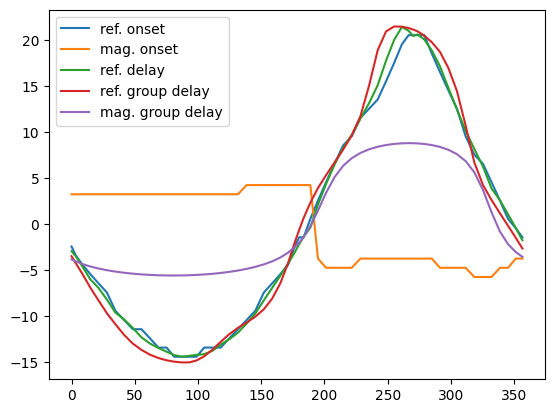

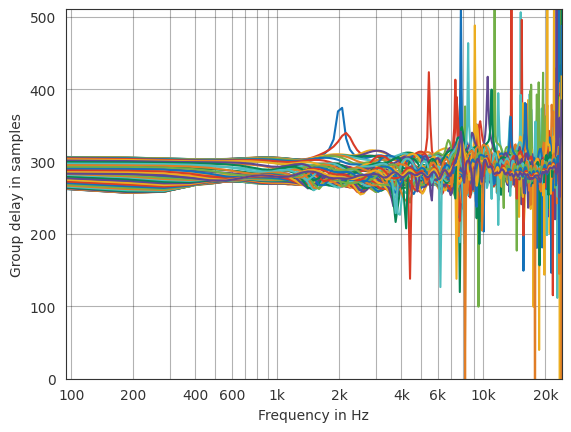

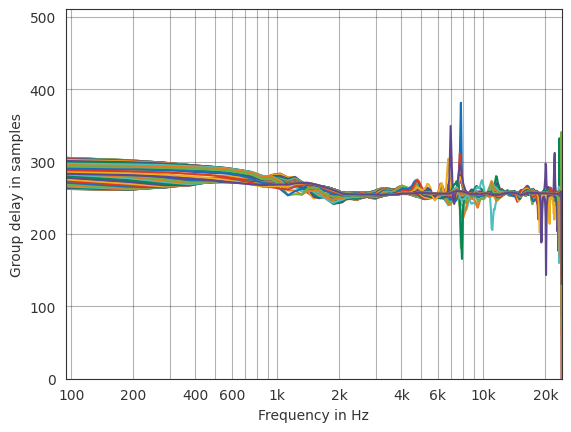

In [13]:
# %% tested with pyfar 0.6.5
import pyfar as pf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# read in data (sources are identical for both)
ref, sources, *_ = pf.io.read_sofa('/Users/orberebi/Library/CloudStorage/GoogleDrive-berebio@post.bgu.ac.il/My Drive/research/iMagLS/TUB-Alurazation/30_04_24-save-test/lambda-vec1_1_1_1_1/sofa_export/ref.sofa')
mag, *_ = pf.io.read_sofa('/Users/orberebi/Library/CloudStorage/GoogleDrive-berebio@post.bgu.ac.il/My Drive/research/iMagLS/TUB-Alurazation/30_04_24-save-test/lambda-vec1_1_1_1_1/sofa_export/MagLS.sofa')

# get horizontal plane data
horizontal = np.abs(sources.elevation) < (.1 / 180 * np.pi)
azimuth = sources.azimuth[horizontal] / np.pi * 180

# low-pass
f_lp = 3e3
N_lp = 10
ref_lp = pf.dsp.filter.butterworth(ref[horizontal, 0], N_lp, f_lp)
mag_lp = pf.dsp.filter.butterworth(mag[horizontal, 0], N_lp, f_lp)

# low-pass group delay
impulse = pf.signals.impulse(2**12)
grp_lp = pf.dsp.group_delay(
    pf.dsp.filter.butterworth(impulse, N_lp, f_lp))
delay_lp = np.mean(grp_lp[:impulse.find_nearest_frequency(f_lp / 4)])

# -> left ear TOA from onset detection
toa_ref_ons = pf.dsp.find_impulse_response_start(ref_lp, 10) - delay_lp
toa_mag_ons = pf.dsp.find_impulse_response_start(mag_lp, 10) - delay_lp

# -> left ear TOA based on delay estimation (cross-correlation with min phase)
toa_ref_del = pf.dsp.find_impulse_response_delay(ref_lp)
# toa_mag_del = pf.dsp.find_impulse_response_delay(mag_lp)  # throws an error

# -> left ear TOA from group delay
# compute group delay using FFT based method (avoid phase unwrapping)
ref_tau = pf.dsp.group_delay(ref[horizontal, 0])
mag_tau = pf.dsp.group_delay(mag[horizontal, 0])
# average group delay below x Hz
# NOTE: - 1.5 kHz would be a common value and showing clear degradations for
#         low order HRTFs
#       - going lower, e.g., to 200 Hz shows that ITD is preserved in this
#         range
f_idx = ref.find_nearest_frequency(1.5e3)
toa_ref_grp = np.mean(ref_tau[:, :f_idx], -1)
toa_mag_grp = np.mean(mag_tau[:, :f_idx], -1)

normalize = True
for data in [
        [toa_ref_ons, 'ref. onset'],
        [toa_mag_ons, 'mag. onset'],
        [toa_ref_del, 'ref. delay'],
        # [toa_mag_del, 'mag. delay'],  # can not be computed
        [toa_ref_grp, 'ref. group delay'],
        [toa_mag_grp, 'mag. group delay'],
        ]:
    offset = np.mean(data[0]) if normalize else 0
    plt.plot(azimuth, data[0] - offset, label=data[1])

plt.legend()

# %% plot group delay for both cases

plt.figure()
ax = pf.plot.group_delay(ref[horizontal, 0], unit='samples')
ax.set_ylim(0, ref.n_samples-1)

plt.figure()
ax = pf.plot.group_delay(mag[horizontal, 0], unit='samples')
ax.set_ylim(0, ref.n_samples-1)




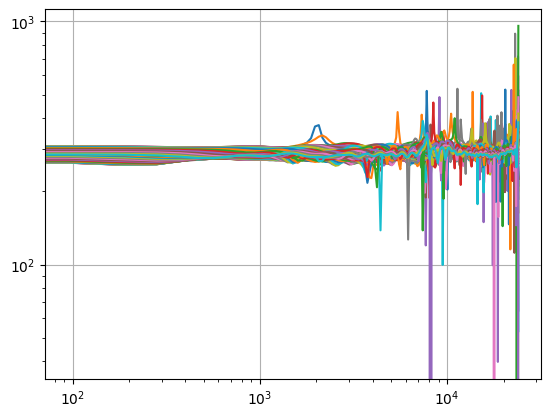

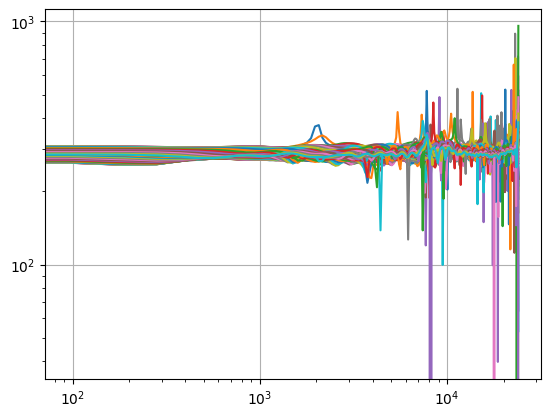

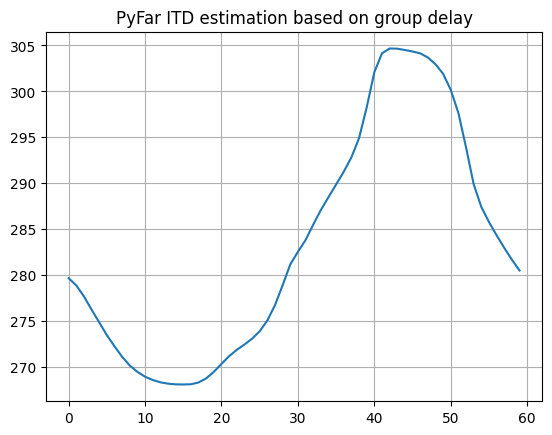

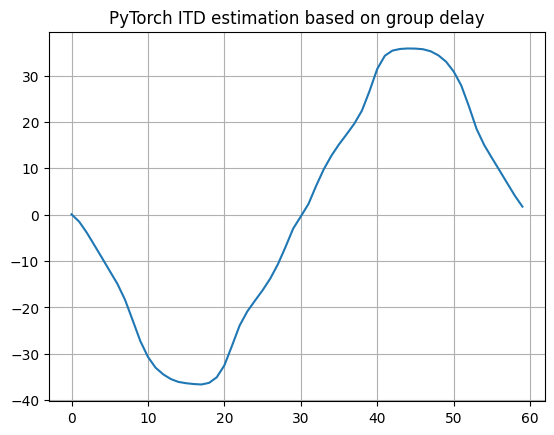

In [93]:
import torch

def group_delay_multi_channel(impulse_response):
    # Get the shape of the input tensor
    N, ch = impulse_response.shape

    # Compute the DFT of the impulse response for all channels
    dft_h = torch.fft.fft(impulse_response, dim=0, norm='forward')

    # Construct the nh[n] sequence for all channels
    n = torch.arange(N).reshape(-1, 1)
    nh = n * impulse_response

    # Compute the DFT of nh[n] for all channels
    dft_nh = torch.fft.fft(nh, dim=0, norm='forward')

    # Calculate the group delay for all channels
    group_delays = torch.real(dft_nh / dft_h)

    # Only retain the positive frequency components
    group_delays = group_delays[:int(N/2)+1, :]

    return group_delays

# Example usage

ref, sources, *_ = pf.io.read_sofa('/Users/orberebi/Library/CloudStorage/GoogleDrive-berebio@post.bgu.ac.il/My Drive/research/iMagLS/TUB-Alurazation/30_04_24-save-test/lambda-vec1_1_1_1_1/sofa_export/ref.sofa')
# get horizontal plane data
horizontal = np.abs(sources.elevation) < (.1 / 180 * np.pi)
azimuth = sources.azimuth[horizontal] / np.pi * 180

f_vec = np.linspace(0,ref.sampling_rate/2,ref.n_bins)
# low-pass
f_lp = 3e3
N_lp = 10
ref_lp = pf.dsp.filter.butterworth(ref[horizontal, 0], N_lp, f_lp)

impulse_response = torch.tensor(ref[horizontal, 0].time).permute(1,0)
ref_tau = pf.dsp.group_delay(ref[horizontal, 0]).T

f_idx = ref.find_nearest_frequency(1.5e3)
toa_ref_grp = np.mean(ref_tau[:f_idx,:], 0)
#toa_ref_grp = toa_ref_grp - toa_ref_grp[0]

group_delay_result_L = group_delay_multi_channel(impulse_response)
TOA_L = torch.mean(group_delay_result_L[:f_idx,:], 0)

impulse_response = torch.tensor(ref[horizontal, 1].time).permute(1,0)
group_delay_result_R = group_delay_multi_channel(impulse_response)
TOA_R = torch.mean(group_delay_result_R[:f_idx,:], 0)
#foo = foo - foo[0]



plt.figure
plt.loglog(f_vec,group_delay_result)
plt.grid(True)
plt.show()



plt.figure
plt.loglog(f_vec,ref_tau)
plt.grid(True)
plt.show()




plt.figure
plt.plot(toa_ref_grp)
plt.grid(True)
plt.title("PyFar ITD estimation based on group delay")
plt.show()


plt.figure
plt.plot(TOA_L - TOA_R)
plt.grid(True)
plt.title("PyTorch ITD estimation based on group delay")
plt.show()
